In [1]:
import pandas as pd
import numpy as np
import lasio
import matplotlib.pyplot as plt
las = lasio.read(r'1050383876.las')

In [3]:
#Headers and units of the las file
las.curves

[CurveItem(mnemonic="DEPT", unit="FT", value="0 000 00 00", descr="Depth", original_mnemonic="DEPT", data.shape=(7056,)),
 CurveItem(mnemonic="CNPOR", unit="PU", value="0", descr="CN Selected Porosity", original_mnemonic="CNPOR", data.shape=(7056,)),
 CurveItem(mnemonic="DCAL", unit="IN", value="0", descr="Caliper from Density Tool", original_mnemonic="DCAL", data.shape=(7056,)),
 CurveItem(mnemonic="DPOR", unit="PU", value="0", descr="Density Porosity", original_mnemonic="DPOR", data.shape=(7056,)),
 CurveItem(mnemonic="GR", unit="GAPI", value="0", descr="Gamma Ray", original_mnemonic="GR", data.shape=(7056,)),
 CurveItem(mnemonic="RHOB", unit="G/CC", value="0", descr="Bulk Density", original_mnemonic="RHOB", data.shape=(7056,)),
 CurveItem(mnemonic="RHOC", unit="G/CC", value="0", descr="Density Correction", original_mnemonic="RHOC", data.shape=(7056,)),
 CurveItem(mnemonic="RILD", unit="OHM-M", value="0", descr="DIL Deep Resistivity", original_mnemonic="RILD", data.shape=(7056,)),
 C

In [4]:
df = las.df() 

In [5]:
df.head(5)

,CNPOR,DCAL,DPOR,GR,RHOB,RHOC,RILD,RILM,RLL3,RXORT,SP,MEL15,MEL20,DT,ITT,MELCAL,SPOR
DEPT,,,,,,,,,,,,,,,,,
6.0,NaN,NaN,NaN,23.8362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6.5,NaN,NaN,NaN,28.8864,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.0,NaN,NaN,NaN,33.1935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7.5,NaN,NaN,NaN,34.6154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8.0,NaN,NaN,NaN,36.0153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
df.columns

Index(['CNPOR', 'DCAL', 'DPOR', 'GR', 'RHOB', 'RHOC', 'RILD', 'RILM', 'RLL3',
       'RXORT', 'SP', 'MEL15', 'MEL20', 'DT', 'ITT', 'MELCAL', 'SPOR'],
      dtype='object')

In [8]:
#Extracting RHOB & DT to generate Synthetic Seismogram
df_selected = df[['RHOB', 'DT']]

In [9]:
#number of NaN in each columns
df_selected.isna().sum(axis=0)

RHOB    2026
DT        51
dtype: int64

In [10]:
df_dropped = df_selected.dropna(subset=['RHOB', 'DT'],axis=0, how='any')

In [11]:
#Filtering
df_dropped = df_dropped.loc[(df_dropped.RHOB> 1) & (df_dropped.RHOB<= 3)]
df_dropped = df_dropped.loc[(df_dropped.DT > 30) & (df_dropped.DT <= 140)]

In [13]:
df_idx = df_dropped.rename_axis('Depth').reset_index()
df_idx.head()

,Depth,RHOB,DT
0,1000.0,2.9297,51.7747
1,1000.5,2.9385,51.9790
2,1001.0,2.9348,52.0958
3,1001.5,2.9106,52.1265
4,1002.0,2.8825,52.0743


In [27]:
def log_plot(logs):
    logs = logs.sort_values(by='Depth')
    top = logs.Depth.min()
    bot = logs.Depth.max()
    
    f, ax = plt.subplots(nrows=1, ncols=2, figsize=(7,20))
    ax[0].plot(logs.DT, logs.Depth, color='black')
    ax[1].plot(logs.RHOB, logs.Depth, color='brown')
    
    
    for i in range(len(ax)):
        ax[i].set_ylim(top,bot)
        ax[i].invert_yaxis()
        ax[i].grid()
        

    ax[0].set_ylabel("Depth(ft)")

    ax[0].set_xlabel("DT")
    ax[0].set_xlim(logs.DT.min(),logs.DT.max())
    ax[1].set_xlabel("RHOB")
    ax[1].set_xlim(logs.RHOB.min(),logs.RHOB.max())

    
    ax[0].set_yticklabels([])
    ax[1].set_yticklabels([])
 
    f.suptitle('Density & Sonic Log', fontsize=14,y=0.89)

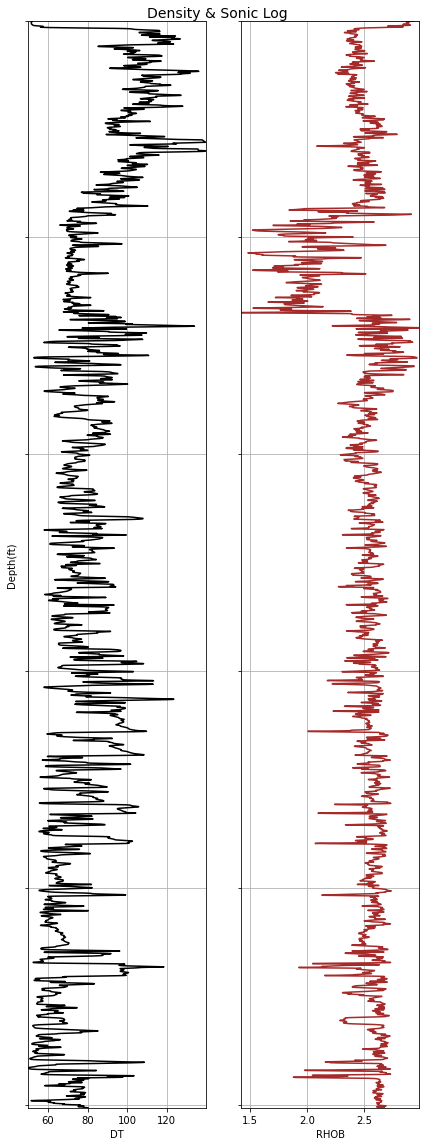

In [28]:
log_plot(df_idx)

In [30]:
seismo = df_idx.copy()

In [31]:
seismo['RHOB']=seismo['RHOB']*1000  #kg/m2

In [32]:
seismo['DT'] = seismo['DT'] / 0.3048   #unit convert to µs/m
seismo['Vsonic'] = 1e6/seismo.DT        #conversion to m/s

In [33]:
#Accoustic Impedence
seismo['AI'] = seismo['Vsonic'] * seismo['RHOB'] 

In [34]:
Imp = seismo['AI'].values
Rc=[]
for i in range(len(Imp)-1):
    Rc.append((Imp[i+1]-Imp[i])/(Imp[i]+Imp[i+1]))

#Reflectivity coefficient
Rc.append(Rc[-1])

In [35]:
seismo['Rc'] = pd.Series(Rc, index=seismo.index)

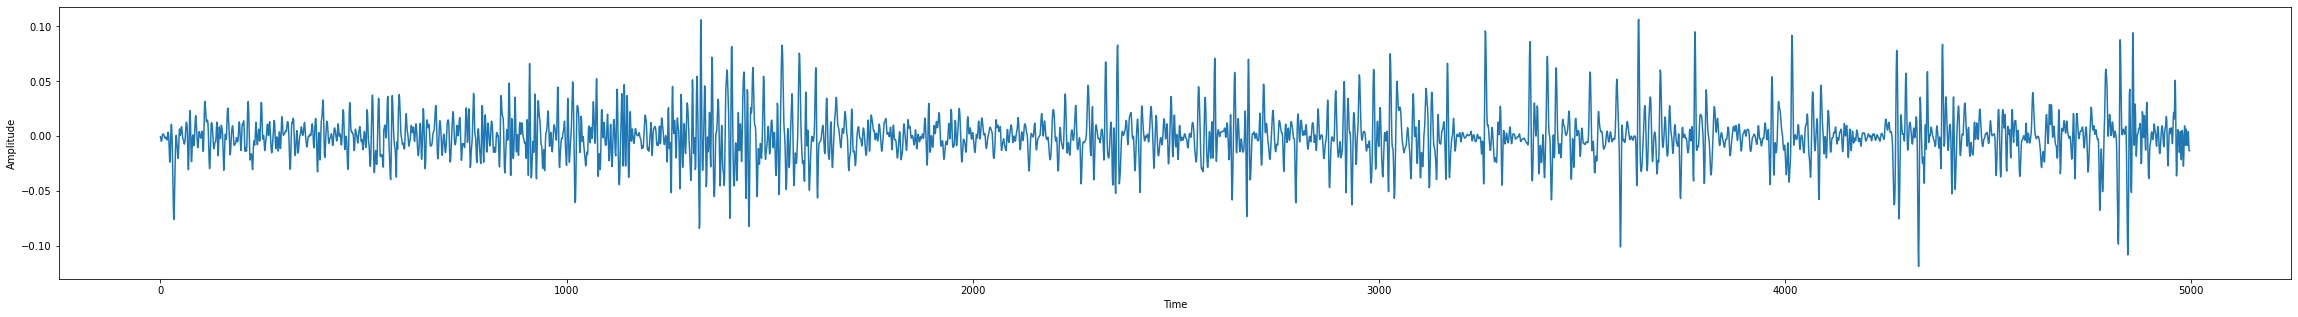

In [37]:
fig = plt.figure()
fig.set_figwidth(40)
fig.set_figheight(5)
plt.xlabel("Time") #Couldn't convert domain to time {assuming depth to be time}
plt.ylabel("Amplitude")
plt.plot(seismo['Rc'])

In [68]:
#Convultion using Ricker Wavelet
def ricker(f, length, dt):
    t0 = np.arange(-length/2, (length-dt)/2, dt)
    y = (1.0 - 2.0*(np.pi**2)*(f**2)*(t0**2)) * np.exp(-(np.pi**2)*(f**2)*(t0**2))
    return t0, y

N=4997

In [69]:
f=30          #wavelet frequency
length=0.512    #Wavelet vector length
dt=0.002        # Sampling prefer to use smiliar to resampled AI
t0, w = ricker (f, length, dt) 
synthetic_30 = np.convolve(w, Rc, mode='same')

In [70]:
f=60          #wavelet frequency
length=0.512    #Wavelet vector length
dt=0.002        
t0, w = ricker (f, length, dt) 
synthetic_60 = np.convolve(w, Rc, mode='same')

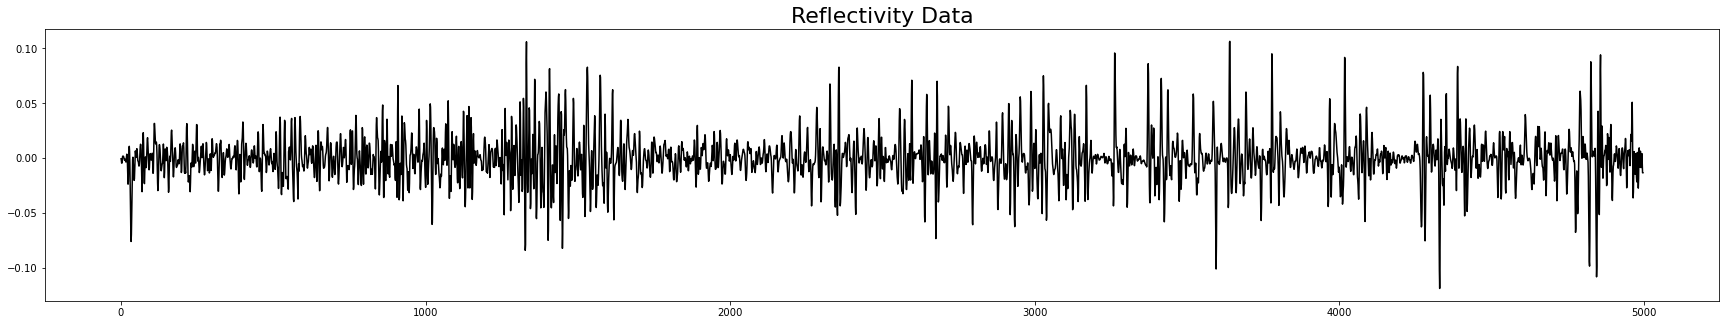

In [160]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Reflectivity Data", fontsize= 22)
plt.plot(seismo['Rc'],color='black')

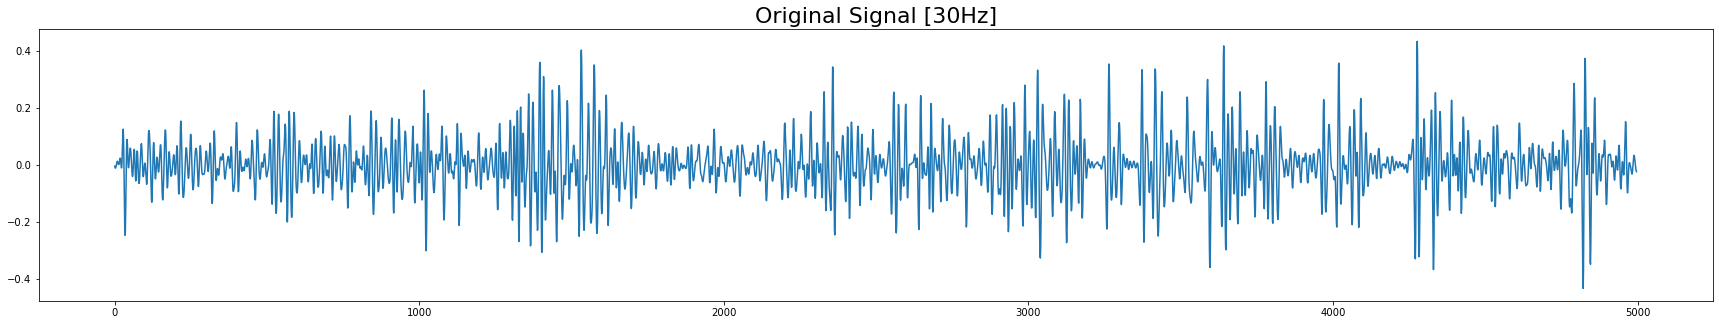

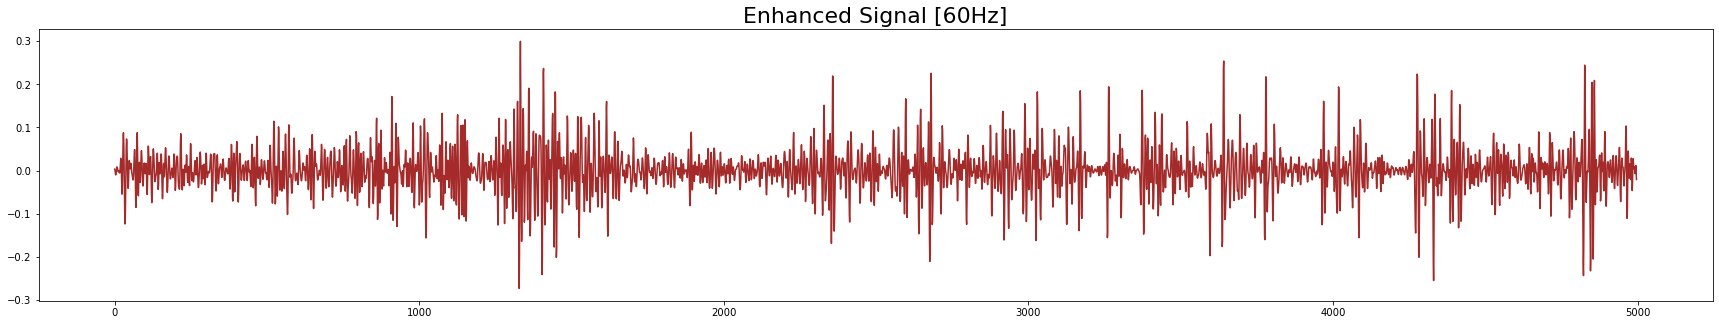

In [71]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Original Signal [30Hz]", fontsize= 22)
plt.plot(synthetic_30)

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Enhanced Signal [60Hz]",fontsize= 22)
plt.plot(synthetic_60,color='brown')

In [72]:
#Fourier Transform
Fs = 500#Hz
xf = (np.fft.fft(synthetic_30))
xf_mag = np.abs(xf)
xf_normalized = xf_mag/N
f = np.arange(Fs/-2,Fs/2, Fs/N)
yf = np.fft.fft(synthetic_60) #has complex values
yf_mag = np.abs(yf)
yf_normalized = yf_mag/N

In [74]:
#using sampling theorem, if we have frequency of 500Hz, we will be able to construct a signal at 250Hz
f_plot = f[0:int(N/2)]
yf_plot = 2 * yf_normalized[0:int(N/2)]
xf_plot = 2* xf_normalized[0:int(N/2)]

Text(0.5, 1.0, 'Enhanced Signal')

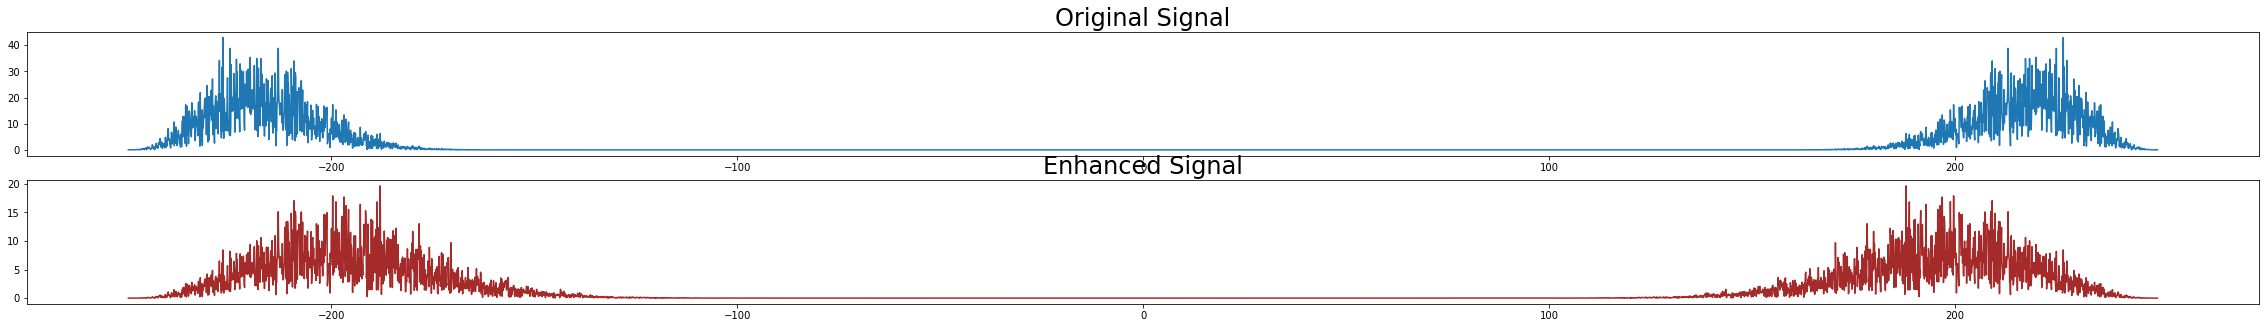

In [78]:
fig, axs = plt.subplots(2,1,figsize=(30,6))
fig.set_figwidth(40)
fig.set_figheight(5)
axs[0].plot(f, xf_mag)
axs[0].set_title('Original Signal', fontsize = 24)
axs[1].plot(f, yf_mag,color='brown')
axs[1].set_title('Enhanced Signal', fontsize = 24)

Text(0.5, 1.0, 'Enhanced Signal')

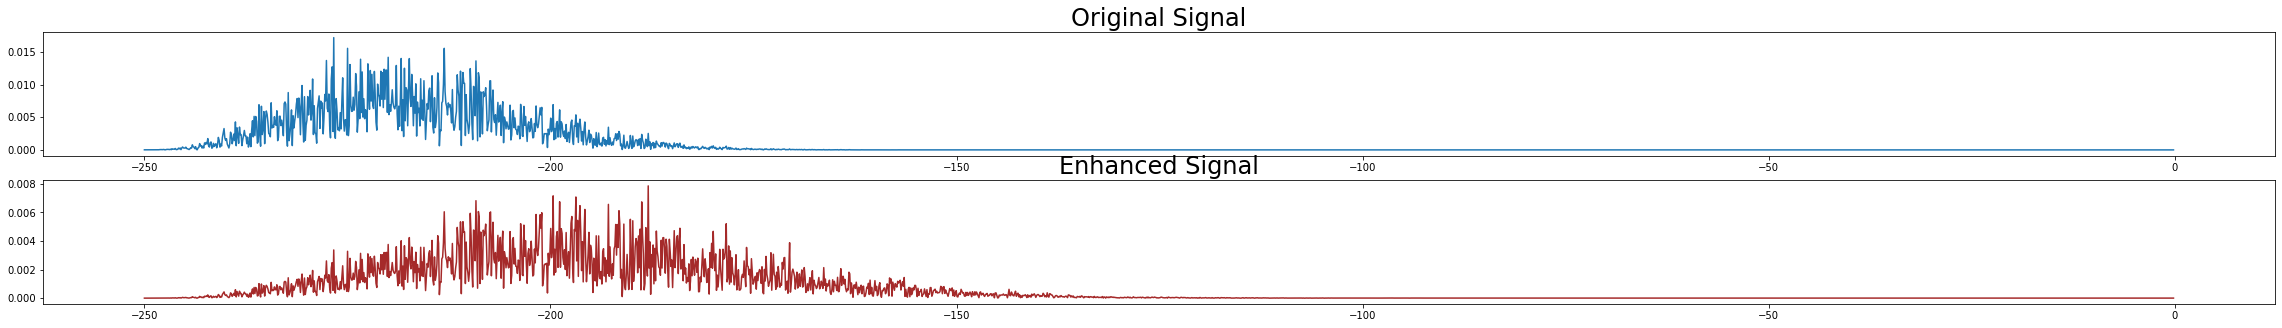

In [82]:
fig, axs = plt.subplots(2,1,figsize=(25,10))
fig.set_figwidth(40)
fig.set_figheight(5)
axs[0].plot(f_plot, xf_plot)
axs[0].set_title('Original Signal', fontsize = 24)
axs[1].plot(f_plot, yf_plot,color='brown')
axs[1].set_title('Enhanced Signal', fontsize = 24)

In [83]:
#Deep Learning using U-NET

In [131]:
from tensorflow.keras.layers import Activation, Dense, Dropout, Conv1D, Conv1DTranspose, MaxPooling1D, Concatenate, Input, Cropping1D, Flatten, UpSampling1D
from keras.models import Model
from tensorflow import keras

In [132]:
x = synthetic_30[:1024]
y = synthetic_60[:1024]

In [134]:
l1 = Input(shape=(1024,1))
#1024x1
l2 = Conv1D(32, 1, activation = 'tanh')(l1) #1024x32
l3 = Conv1D(32, 1, activation = 'tanh')(l2) #1024 x 32
l4 = MaxPooling1D(pool_size=2,strides=2, padding='same')(l3)#512 x 32
#print(pool_1.shape)

l5 = Conv1D(64, 1, activation = 'tanh')(l4)#512 x 64
l6 = Conv1D(64, 1, activation = 'tanh')(l5)#512 x 64
l7 = MaxPooling1D(pool_size=2,strides=2, padding='same')(l6)#256 x 64

l8 = Conv1D(128, 1, activation = 'tanh')(l7)#256 x 128
l9 = Conv1D(128, 1, activation = 'tanh')(l8)#256 x 128
l10 = MaxPooling1D(pool_size=2,strides=2, padding='same')(l9)#128 x 128

l11 = Conv1D(256, 1, activation = 'tanh')(l10)#128 x 256
l12 = Conv1D(256, 1, activation = 'tanh')(l11)#128 x 256



#Deconvolution or expanding layer
l13 = Conv1DTranspose(128, 1,strides=2,padding="same")(l12) #256 x 128
#print(l13.shape)
l14 = Concatenate(axis=2)([l13,l9])#256 x 256

l15 = Conv1D(128,1, activation ='tanh')(l14)#256 x 128
#print(l15.shape)
l16 = Conv1D(128,1, activation ='tanh')(l15)#256 x 128

l17 = Conv1DTranspose(64,1,strides=2,padding="same" )(l16)#512 x 64
#print(l17.shape)
l18 = Concatenate(axis = 2)([l17,l6])#512x128

l19 = Conv1D(64,1, activation ='tanh')(l18)#512x64
l20 = Conv1D(64,1, activation ='tanh')(l19)


l21 = Conv1DTranspose(32,1,strides=2,padding="same" )(l20)#1024 x 32
#print(l21.shape)
l22 = Concatenate(axis = 2)([l21,l3])#1024x64
l23 = Conv1D(32,1, activation ='tanh')(l22)#1024x32

#l24 = Conv1DTranspose(1,1,strides=2,padding="same" )(l23)
#l25 = Conv1D(1, 1,activation ='tanh')(l24)

out = Conv1D(1, 1,activation ='tanh')(l23)


In [135]:
u_net = Model(l1,out)

u_net.compile(optimizer ='adam', loss ='mse')

inp = x.reshape(1,1024)
out = y.reshape(1,1024)

In [136]:
u_net.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 1024, 1)]    0                                            
__________________________________________________________________________________________________
conv1d_92 (Conv1D)              (None, 1024, 32)     64          input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_93 (Conv1D)              (None, 1024, 32)     1056        conv1d_92[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_21 (MaxPooling1D) (None, 512, 32)      0           conv1d_93[0][0]                  
_______________________________________________________________________________________

In [137]:
u_net.fit(inp,out,epochs=28,batch_size=2)

Epoch 1/28
1/1 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 2/28
1/1 [==============================] - 0s 998us/step - loss: 0.0139
Epoch 3/28
1/1 [==============================] - 0s 2ms/step - loss: 0.0017
Epoch 4/28
1/1 [==============================] - 0s 998us/step - loss: 0.0025
Epoch 5/28
1/1 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 6/28
1/1 [==============================] - 0s 3ms/step - loss: 0.0019
Epoch 7/28
1/1 [==============================] - 0s 1000us/step - loss: 0.0012
Epoch 8/28
1/1 [==============================] - 0s 4ms/step - loss: 0.0014
Epoch 9/28
1/1 [==============================] - 0s 2ms/step - loss: 0.0014
Epoch 10/28
1/1 [==============================] - 0s 998us/step - loss: 9.9981e-04
Epoch 11/28
1/1 [==============================] - 0s 4ms/step - loss: 8.6022e-04
Epoch 12/28
1/1 [==============================] - 0s 1000us/step - loss: 0.0010
Epoch 13/28
1/1 [==============================] - 0s

In [138]:
pred = u_net.predict(inp)

In [139]:
y_pred=pred[0].reshape(-1,1)
y_pred.shape

(1024, 1)

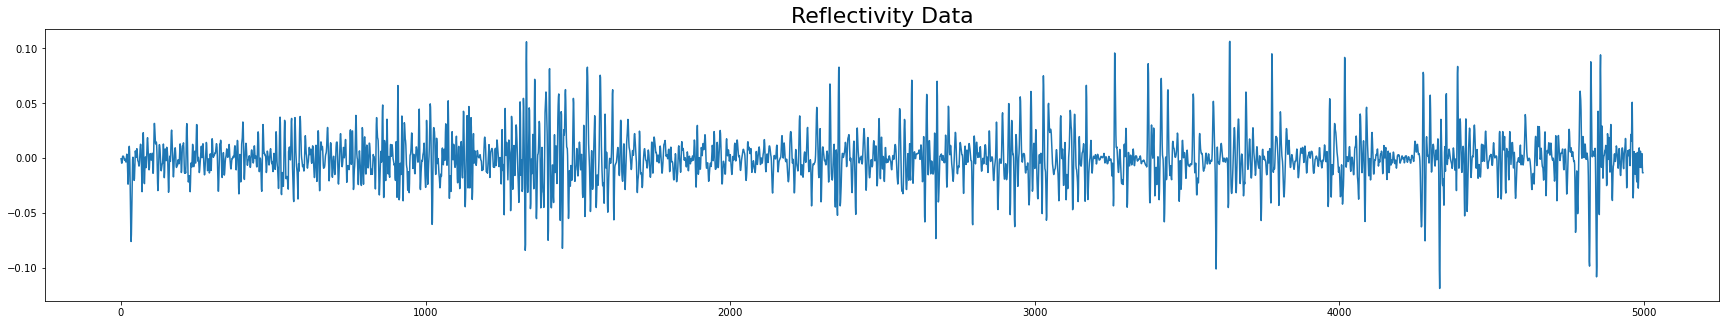

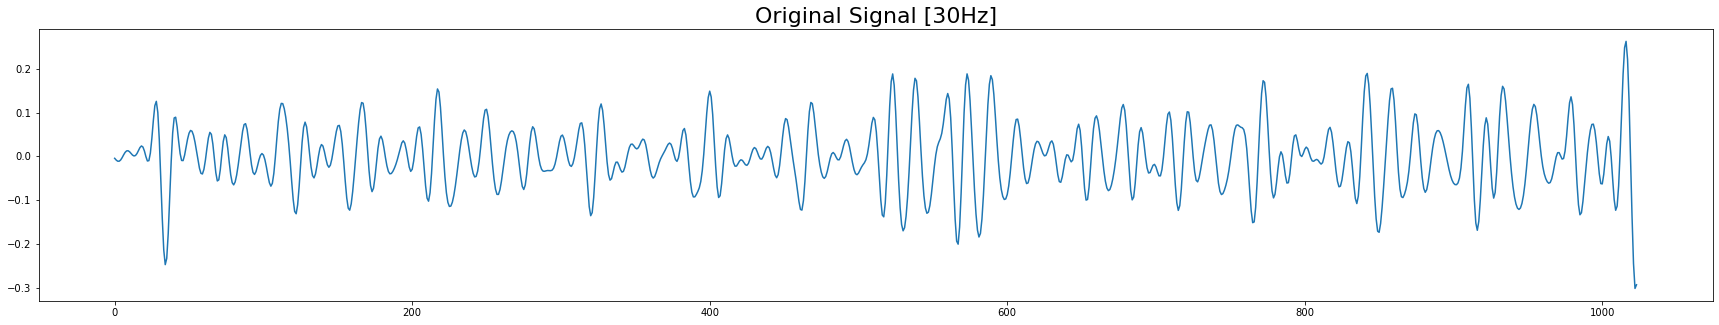

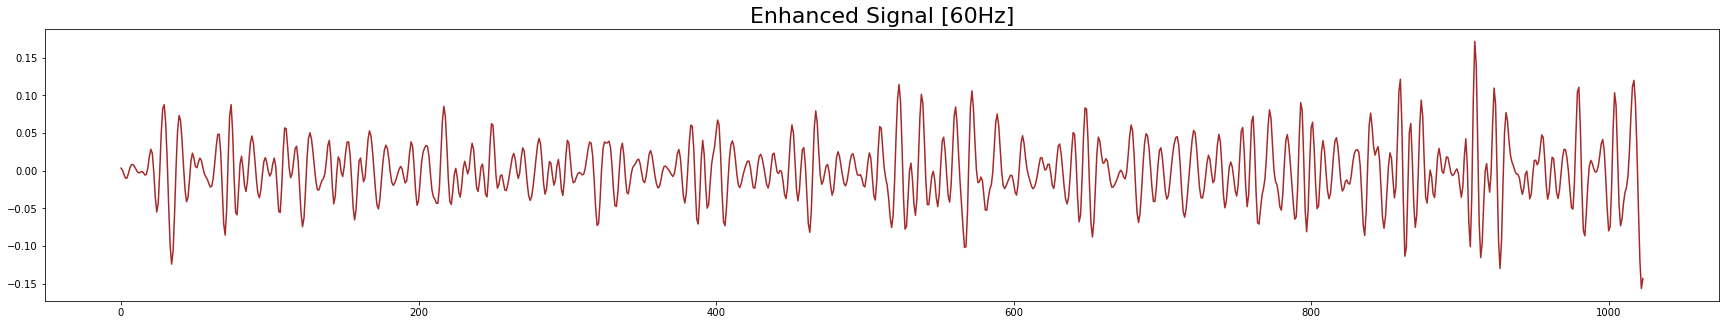

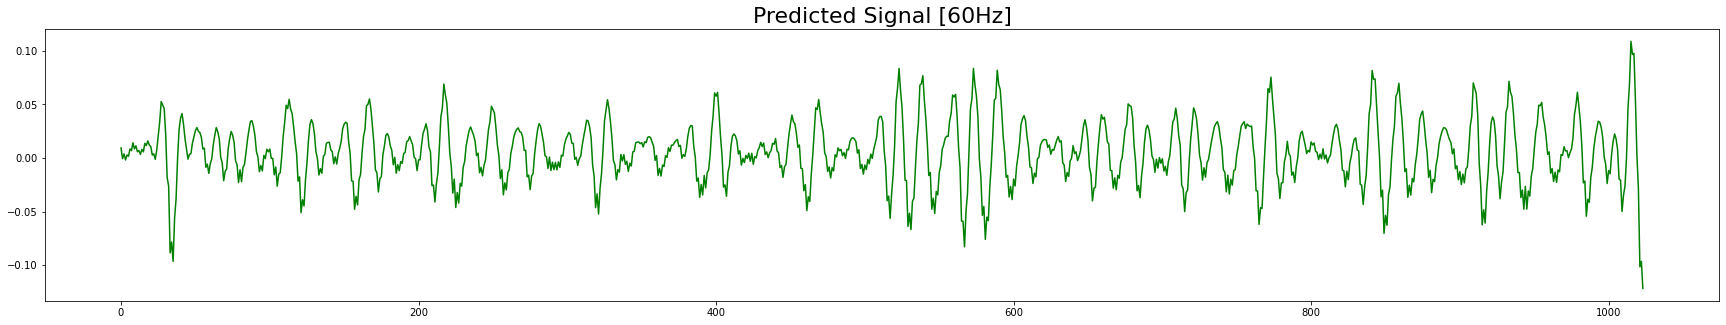

In [147]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Original Signal [30Hz]", fontsize= 22)
plt.plot(x)

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Enhanced Signal [60Hz]",fontsize= 22)
plt.plot(y,color='brown')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Predicted Signal [60Hz]",fontsize= 22)
plt.plot(y_pred,color='green')

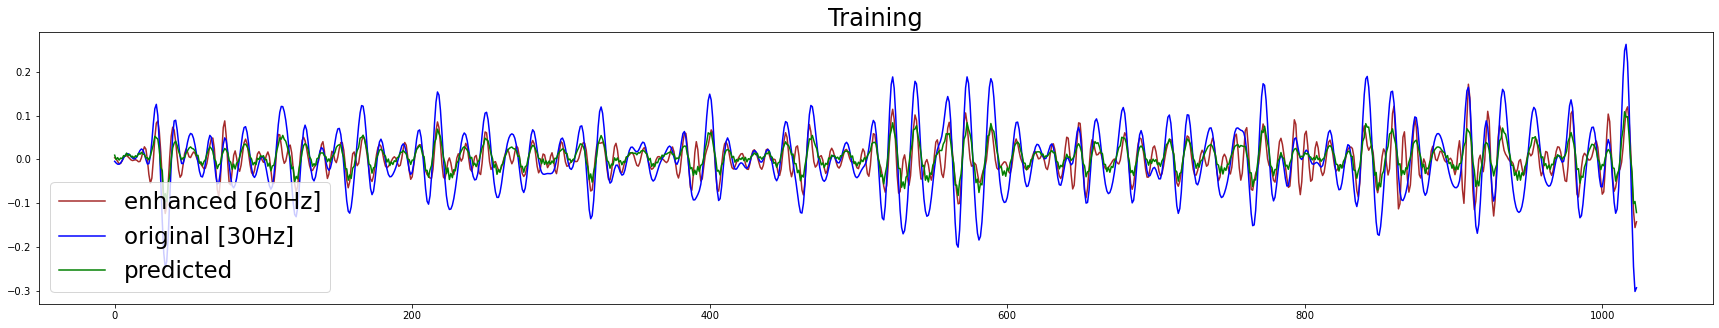

In [159]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Training",fontsize= 24)
plt.plot(y,color='brown',label='enhanced [60Hz]')
plt.plot(x,color='blue',label='original [30Hz]')
plt.plot(y_pred,color='green',label='predicted')
plt.legend(fontsize=23,loc='best')

In [149]:
#u_net.save("curentttttt")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: curentttttt\assets


In [150]:
x_test = synthetic_30[1024:2048].reshape(1,1024)
y_test = synthetic_60[1024:2048].reshape(1,1024)

In [152]:
test_pred = u_net.predict(x_test)

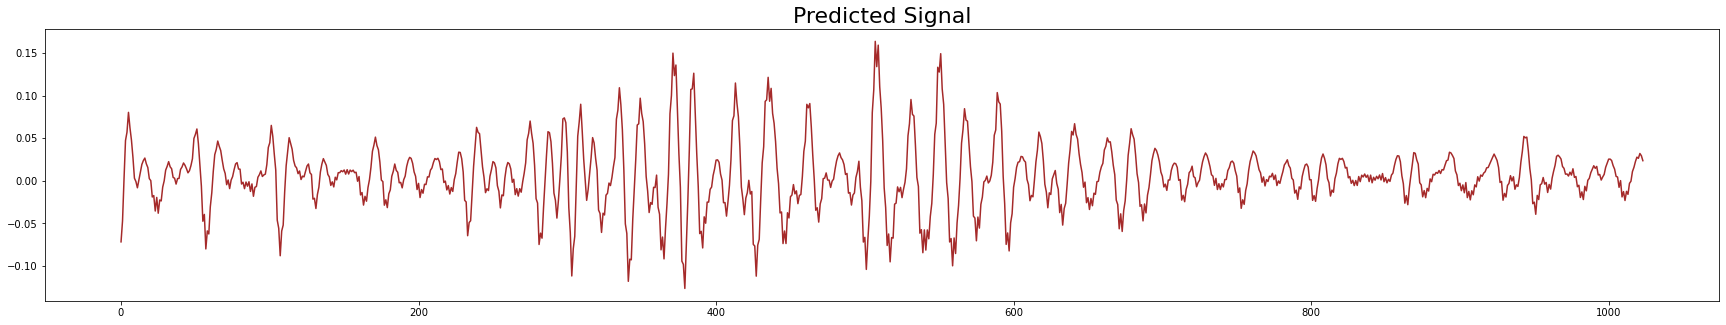

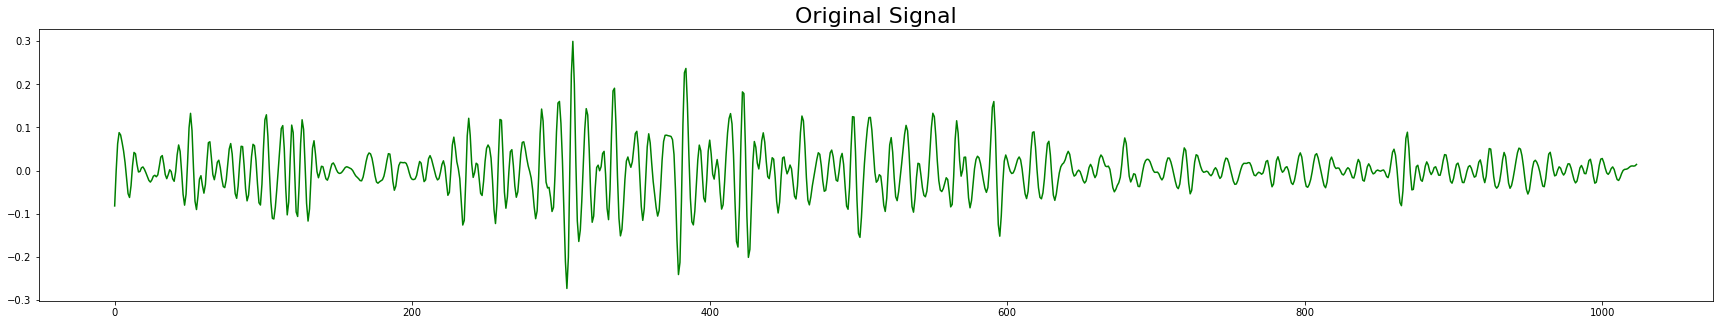

In [154]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Predicted Signal",fontsize= 22)
plt.plot(test_pred[0],color='brown')

f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Original Signal",fontsize= 22)
plt.plot(synthetic_60[1024:2048],color='green')


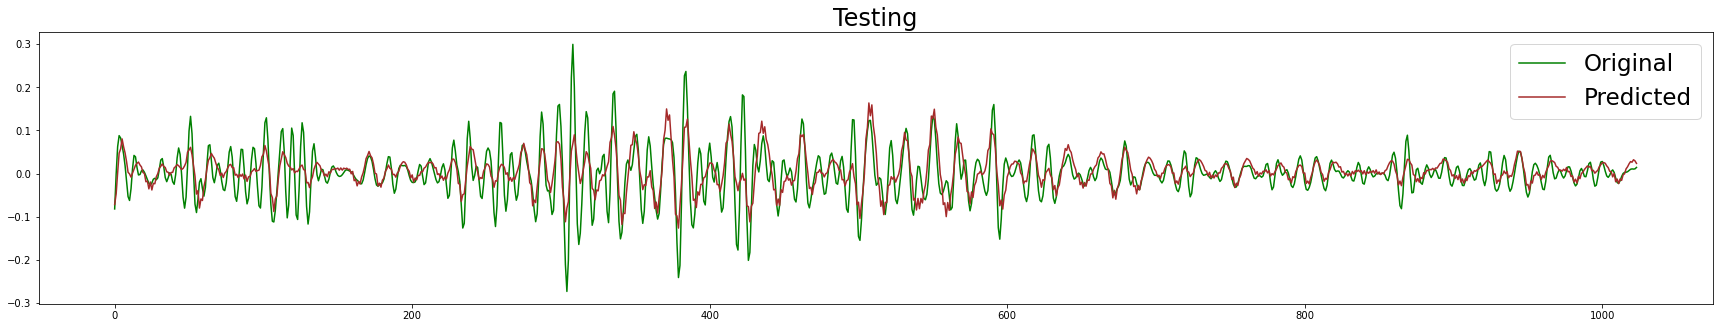

In [158]:
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.title("Testing",fontsize= 24)
plt.plot(synthetic_60[1024:2048],color='green',label='Original')
plt.plot(test_pred[0],color='brown',label='Predicted')

plt.legend(fontsize=23,loc='best')

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential

In [12]:
from keras.models import load_model
u_net_ = tf.keras.models.load_model("curentttttt")


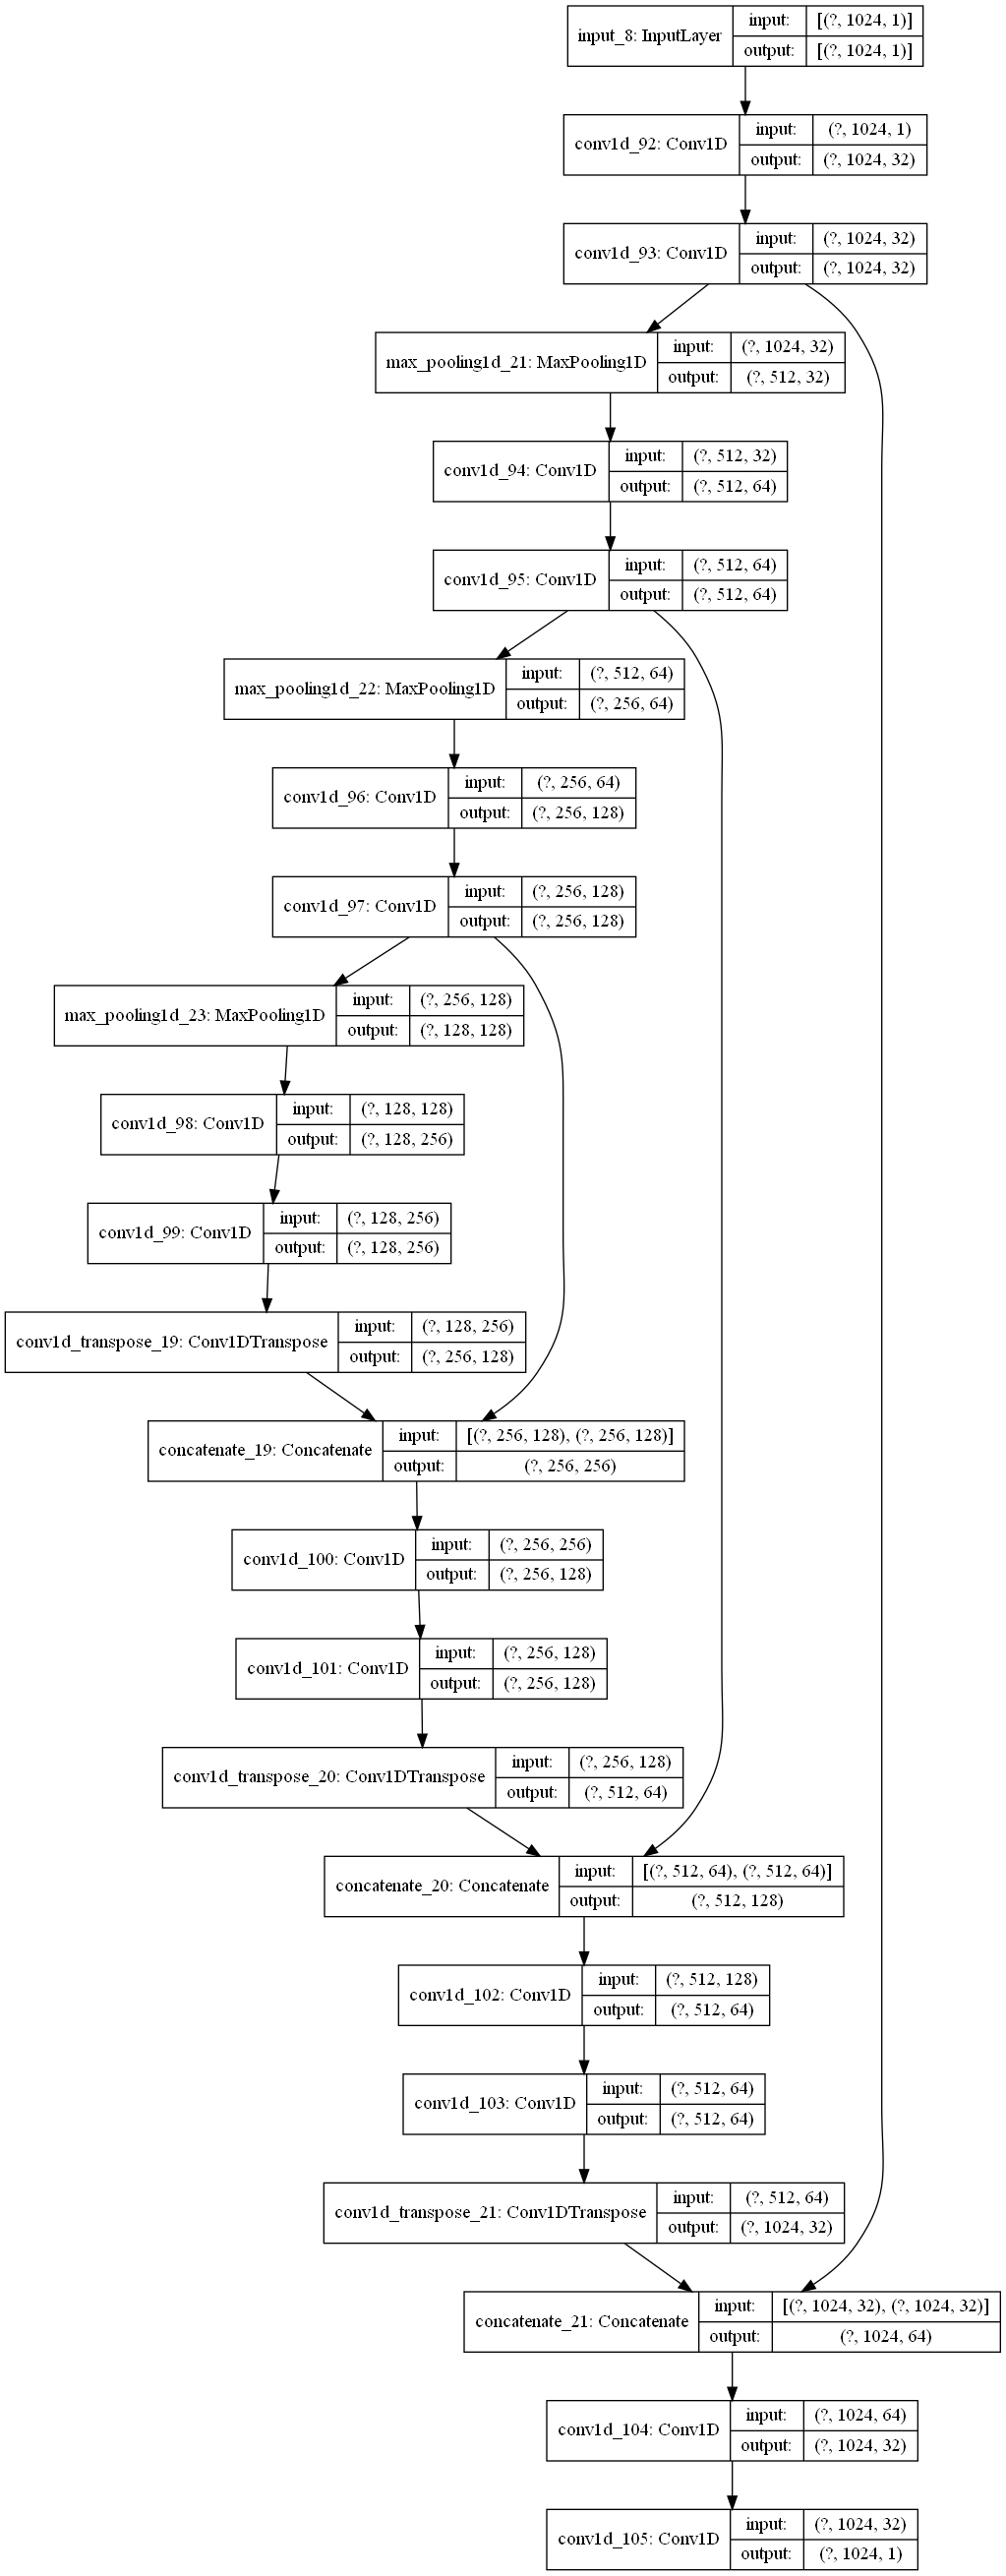

In [14]:
keras.utils.plot_model(u_net_, to_file = "Model.png", show_shapes=True)